Enter the value of n (size of the puzzle grid):  3


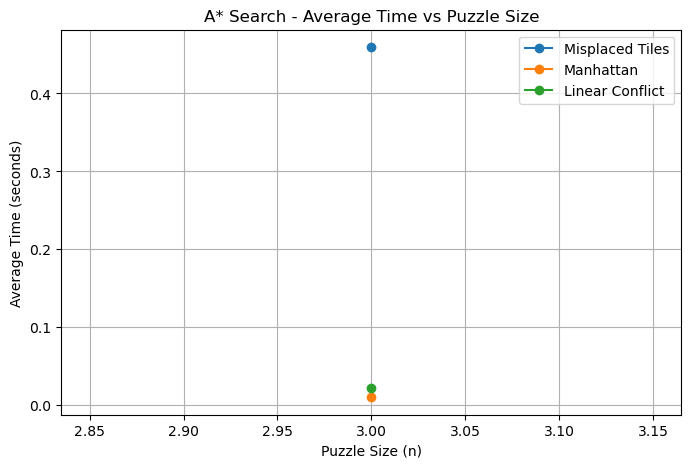

In [5]:

import numpy as np
import heapq
import random
import time
import matplotlib.pyplot as plt

def is_solvable(puzzle):
    flat_puzzle = puzzle.flatten()
    inv_count = sum(1 for i in range(len(flat_puzzle)) for j in range(i + 1, len(flat_puzzle))
                    if flat_puzzle[i] and flat_puzzle[j] and flat_puzzle[i] > flat_puzzle[j])
    return inv_count % 2 == 0

def generate_puzzle(n):
    while True:
        numbers = list(range(n * n))
        random.shuffle(numbers)
        puzzle = np.array(numbers).reshape(n, n)
        if is_solvable(puzzle):
            return puzzle

def goal_state(n):
    goal = np.arange(1, n * n)
    goal = np.append(goal, 0).reshape(n, n)
    return goal

def goal_position(n):
    goal = goal_state(n)
    return {goal[row, col]: (row, col) for row in range(n) for col in range(n)}

def find_zero(state):
    return tuple(np.argwhere(state == 0)[0])

def misplaced_tiles(puzzle, goal_pos):
    return np.sum(puzzle[puzzle != 0] != goal_state(puzzle.shape[0])[puzzle != 0])

def manhattan_distance(puzzle, goal_pos):
    n = puzzle.shape[0]
    dist = 0
    for row in range(n):
        for col in range(n):
            value = puzzle[row, col]
            if value != 0:
                goal_row, goal_col = goal_pos[value]
                dist += abs(row - goal_row) + abs(col - goal_col)
    return dist

def linear_conflict(puzzle, goal_pos):
    n = puzzle.shape[0]
    md = manhattan_distance(puzzle, goal_pos)
    lc = 0
    
    for row in range(n):
        row_values = [puzzle[row, col] for col in range(n) if puzzle[row, col] != 0]
        goal_rows = [goal_pos[val][0] for val in row_values]
        for i in range(len(row_values)):
            for j in range(i + 1, len(row_values)):
                if goal_rows[i] == goal_rows[j] and row_values[i] > row_values[j]:
                    lc += 2

    for col in range(n):
        col_values = [puzzle[row, col] for row in range(n) if puzzle[row, col] != 0]
        goal_cols = [goal_pos[val][1] for val in col_values]
        for i in range(len(col_values)):
            for j in range(i + 1, len(col_values)):
                if goal_cols[i] == goal_cols[j] and col_values[i] > col_values[j]:
                    lc += 2

    return md + lc

def move_tile(puzzle, direction, n):
    row, col = find_zero(puzzle)
    new_puzzle = puzzle.copy()
    
    if direction == "up" and row > 0:
        new_puzzle[row, col], new_puzzle[row - 1, col] = new_puzzle[row - 1, col], new_puzzle[row, col]
    elif direction == "down" and row < n - 1:
        new_puzzle[row, col], new_puzzle[row + 1, col] = new_puzzle[row + 1, col], new_puzzle[row, col]
    elif direction == "left" and col > 0:
        new_puzzle[row, col], new_puzzle[row, col - 1] = new_puzzle[row, col - 1], new_puzzle[row, col]
    elif direction == "right" and col < n - 1:
        new_puzzle[row, col], new_puzzle[row, col + 1] = new_puzzle[row, col + 1], new_puzzle[row, col]
    else:
        return None
    return new_puzzle

def a_star_solve(puzzle, n, heuristic, time_limit=60):
    goal_pos = goal_position(n)
    priority_queue = []
    heapq.heappush(priority_queue, (heuristic(puzzle, goal_pos), 0, puzzle.tolist()))
    visited = set()
    start_time = time.time()

    while priority_queue:
        if time.time() - start_time > time_limit:
            return None

        _, cost, current_state = heapq.heappop(priority_queue)
        current_state = np.array(current_state)
        state_tuple = tuple(map(tuple, current_state))

        if state_tuple in visited:
            continue

        visited.add(state_tuple)

        if np.array_equal(current_state, goal_state(n)):
            return time.time() - start_time

        for move in ["left", "right", "up", "down"]:
            new_state = move_tile(current_state, move, n)
            if new_state is not None:
                new_tuple = tuple(map(tuple, new_state))
                if new_tuple not in visited:
                    g = cost + 1
                    h = heuristic(new_state, goal_pos)
                    heapq.heappush(priority_queue, (g + h, g, new_state.tolist()))

    return None

n_values = [int(input("Enter the value of n (size of the puzzle grid): "))]
results = {"Misplaced Tiles": [], "Manhattan": [], "Linear Conflict": []}
heuristics = {"Misplaced Tiles": misplaced_tiles, "Manhattan": manhattan_distance, "Linear Conflict": linear_conflict}

for n in n_values:
    for heuristic_name, heuristic_func in heuristics.items():
        times = []
        for _ in range(10):  
            puzzle = generate_puzzle(n)
            solve_time = a_star_solve(puzzle, n, heuristic_func)
            if solve_time is not None:
                times.append(solve_time)
        avg_time = sum(times) / len(times) if times else float('inf')
        results[heuristic_name].append(avg_time)

plt.figure(figsize=(8, 5))
for heuristic_name, times in results.items():
    filtered_n = [n for i, n in enumerate(n_values) if times[i] != float('inf')]
    filtered_times = [t for t in times if t != float('inf')]
    plt.plot(filtered_n, filtered_times, marker='o', linestyle='-', label=heuristic_name)

plt.xlabel('Puzzle Size (n)')
plt.ylabel('Average Time (seconds)')
plt.title('A* Search - Average Time vs Puzzle Size')
plt.legend()
plt.grid(True)
plt.show()
